# 제11장　화풍변환 Style Transfer

****공통 모듈 읽어들이기****

In [1]:
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import load_img,  img_to_array, array_to_img

**예제 코드11.1:Residual Block을 작성하는 함수 정의**

In [2]:
from tensorflow.python.keras.layers import Conv2D,  BatchNormalization, Add, Activation


def residual_block(input_ts):
    """Residual Block을 구축하는 함수"""
    x = Conv2D(
        128, (3, 3), strides=1, padding='same'
    )(input_ts)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    return Add()([x, input_ts])

**예제 코드11.2:변환 네트워크를 구축하는 encoder-decoder 함수 정의**

In [3]:
from tensorflow.python.keras.layers import Input,  Lambda, Conv2DTranspose
from tensorflow.python.keras.models import Model


def build_encoder_decoder(input_shape=(224, 224, 3)):
    """ 변환용 네트워크 구축"""

    # 인코더 부분
    input_ts = Input(shape=input_shape, name='input')

    # 입력을 [0, 1]의 범위로 정규화
    x = Lambda(lambda a: a/255.)(input_ts)

    x = Conv2D(32, (9, 9), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual Block을 5블록 추가
    for _ in range(5):
        x = residual_block(x)

    # 디코더 부분
    x = Conv2DTranspose(
            64, (3, 3), strides=2, padding='same'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(3, (9, 9), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

    # 출력값이[0, 255]이 되도록 스케일 변환
    gen_out = Lambda(lambda a: (a + 1)*127.5)(x)

    model_gen = Model(
        inputs=[input_ts], 
        outputs=[gen_out]
    )

    return model_gen

input_shape = (224, 224, 3)

# 변환 네트워크 구축
model_gen = build_encoder_decoder(input_shape=input_shape)

Instructions for updating:
Colocations handled automatically by placer.


**예제 코드11.3:학습용 네트워크 구축**

In [4]:
from tensorflow.python.keras.applications.vgg16 import VGG16


# 사전 학습 모델 VGG16 호출
vgg16 = VGG16()

# 가중치 파라미터를 학습하지 않도록 설정
for layer in vgg16.layers:
    layer.trainable = False

# VGG16 을 위한 입력값 전처리 함수
def norm_vgg16(x):
        """RGB->BGR변환과 중심화를 실시하는 함수"""
        return (x[:, :, :, ::-1]  - 120)/255.
    
# 특정 스타일과 컨텐츠를 추출하기 위한 layer 지정
style_layer_names = (
    'block1_conv2', 
    'block2_conv2', 
    'block3_conv3', 
    'block4_conv3'
)
contents_layer_names = ('block3_conv3',)

style_outputs_gen = []
contents_outputs_gen = []

input_gen = model_gen.output  # 변환 네트워크의 출력을 입력으로
z = Lambda(norm_vgg16)(input_gen)  # 입력값 정규화
for layer in vgg16.layers:
    z = layer(z)  # VGG16 의 층을 쌓아 네트워크를 재구축
    if layer.name in style_layer_names:
        # 스타일 특징량 추출용 중간층의 출력 추가
        style_outputs_gen.append(z)
    if layer.name in contents_layer_names:
        # 컨텐츠 특징량 추출용 중간층의 출력 추가
        contents_outputs_gen.append(z)

# 모델 정의
model = Model(
      inputs=model_gen.input,
      outputs=style_outputs_gen + contents_outputs_gen
)

**예제 코드11.4:스타일 원본 이미지 읽어 들이기**

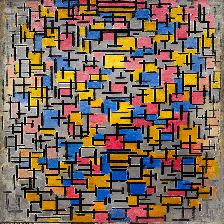

In [5]:
input_size = input_shape[:2]

# 스타일 이미지 읽어 들이기
img_sty = load_img('img/style/Piet_Mondrian_Composition.png', target_size=input_size)

# 스타일 이미지 표시
img_sty

**예제 코드11.5:스타일 원본 이미지를 numpy.ndarray로 변환**

In [6]:
# 읽어 들인 이미지를 numpy.ndarray로 변환
img_arr_sty = np.expand_dims(img_to_array(img_sty), axis=0)

**예제 코드11.6：원본 이미지의 스타일 특징량 추출**

In [7]:
# 입력층 정의
input_sty = Input(shape=input_shape, name='input_sty')

style_outputs = []  # 중간층의 출력을 저장할 리스트
x = Lambda(norm_vgg16)(input_sty)
for layer in vgg16.layers:
    x = layer(x)
    if layer.name in style_layer_names:
        style_outputs.append(x)

# 스타일의 원본 이미지를 입력해서 특징량을 출력할 모델 정의
model_sty = Model(
    inputs=input_sty, 
    outputs=style_outputs
)

# 원본 이미지에서 정답 데이터가 되는 특징량 추출
y_true_sty = model_sty.predict(img_arr_sty)

**컨텐츠 원본 특징량 추출 네트워크 구축**

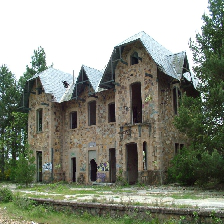

In [8]:
# 컨텐츠 이미지 불러오기
img_con = load_img('img/context/fa076ee97e8f2c40.jpg', target_size=input_size)

# 스타일 이미지 표시
img_con

**예제 코드11.7:원본 이미지의 컨텐츠 특징량 추출용 네트워크 구축**

In [9]:
# 입력층 정의
input_con = Input(shape=input_shape, name='input_con')

contents_outputs = [] # 중간층의 출력을 저장할 리스트
y = Lambda(norm_vgg16)(input_con)
for layer in vgg16.layers:
    y = layer(y)
    if layer.name in contents_layer_names:
        contents_outputs.append(y)

# 컨텐츠의 원본 이미지를 입력해서 특징량을 추출하는 모델 정의
model_con = Model(
    inputs=input_con, 
    outputs=contents_outputs
)

**예제 코드11.8:이미지 불러오기용 함수 정의**

In [10]:
# 이미지 파일 불러오기용 래퍼 함수 정의
def load_imgs(img_paths, target_size=(224, 224)):
    """ 이미지 파일 경로 리스트로부터, 배열의 배치를 반환"""
    _load_img = lambda x: img_to_array(
        load_img(x, target_size=target_size)
    )
    img_list = [
        np.expand_dims(_load_img(img_path), axis=0)
        for img_path in img_paths
    ]
    return np.concatenate(img_list, axis=0)

**예제 코드11.9:생성기용 함수 정의**

In [11]:
import math


def train_generator(img_paths, batch_size, model, y_true_sty, shuffle=True, epochs=None):
    """ 힉습 데이터를 생성하는 생성기"""
    n_samples = len(img_paths)
    indices = list(range(n_samples))
    steps_per_epoch = math.ceil(n_samples / batch_size)
    img_paths = np.array(img_paths)
    cnt_epoch = 0
    while True:
        cnt_epoch += 1
        if shuffle:
            np.random.shuffle(indices)
        for i in range(steps_per_epoch):
            start = batch_size*i
            end = batch_size*(i + 1)
            X = load_imgs(img_paths[indices[start:end]])
            batch_size_act = X.shape[0]
            y_true_sty_t = [
                np.repeat(feat, batch_size_act, axis=0)
                for feat in y_true_sty
            ]
            # 컨텐츠 특징량 추출
            y_true_con = model.predict(X)
            yield (X,  y_true_sty_t + [y_true_con])
        if epochs is not None:
            if cnt_epoch >= epochs:
                raise StopIteration

**예제 코드11.10:생성기 생성**

In [12]:
import glob


# 입력 이미지 파일 경로 취득
path_glob = os.path.join('img/context/*.jpg')
img_paths = glob.glob(path_glob)

# 배치사이즈와 에폭설정
batch_size = 2
epochs = 10

# 생성기 생성
gen = train_generator(
    img_paths, 
    batch_size, 
    model_con,
    y_true_sty,
    epochs=epochs
)

**예제 코드11.11:컨텐츠특징량 손실 함수**

In [13]:
from tensorflow.python.keras import backend as K


def feature_loss(y_true, y_pred):
    """ 컨텐츠특징량 손실 함수 """
    norm = K.prod(K.cast(K.shape(y_true)[1:], 'float32'))
    return K.sum(
        K.square(y_pred - y_true), axis=(1, 2, 3)
    )/norm

**예제 코드11.12:스타일 특징량 손실 함수**

In [14]:
def gram_matrix(X):
    """ 그람 행렬 계산"""
    X_sw = K.permute_dimensions(
        X, (0, 3, 2, 1)
    )  # 軸の入れ替え
    s = K.shape(X_sw)
    new_shape = (s[0], s[1], s[2]*s[3])
    X_rs = K.reshape(X_sw, new_shape)
    X_rs_t = K.permute_dimensions(
        X_rs, (0, 2, 1)
    )  # 행렬을 전치
    dot = K.batch_dot(X_rs, X_rs_t)  # 내적계산
    norm = K.prod(K.cast(s[1:], 'float32'))
    return dot/norm

def style_loss(y_true, y_pred):
    """ 스타일용 손실 함수 정의"""
    return K.sum(
        K.square(
            gram_matrix(y_pred) - gram_matrix(y_true)
        ),
        axis=(1, 2)
    )

**예제 코드11.13：모델과 결과를 저장할 폴더 준비**


In [15]:
import datetime


# 모델과 결과를 저장할 폴더 준비
dt = datetime.datetime.now()
dir_log = 'model/{:%y%m%d_%H%M%S}'.format(dt)
dir_weights = 'model/{:%y%m%d_%H%M%S}/weights'.format(dt)
dir_trans = 'model/{:%y%m%d_%H%M%S}/img_trans'.format(dt)

os.makedirs(dir_log, exist_ok=True)
os.makedirs(dir_weights, exist_ok=True)
os.makedirs(dir_trans, exist_ok=True)

**Total Variation Regularizer의 정의와 정규화항 추가**

In [16]:
# Total Variation Regularizer의 정의
def TVRegularizer(x, weight=1e-6, beta=1.0, input_size=(224, 224)):
    delta = 1e-8
    h, w = input_size
    d_h = K.square(x[:, :h - 1, :w - 1, :] - x[:, 1:, :w - 1, :])
    d_w = K.square(x[:, :h - 1, :w - 1, :] - x[:, :h - 1, 1:, :])
    return weight * K.mean(K.sum(K.pow(d_h + d_w + delta, beta/2.)))

# 정규화항 추가
use_tvr = True
if use_tvr:
    gen_output_layer = model_gen.layers[-1]
    tv_loss = TVRegularizer(gen_output_layer.output)
    gen_output_layer.add_loss(tv_loss)

**예제 코드11.14:모델 컴파일**

In [16]:
#from tensorflow.python.keras.optimizers import Adadelta
from keras import optimizers
# 모델 컴파일
model.compile(
      optimizer=tf.train.AdadeltaOptimizer(),
      loss=[
            style_loss, 
            style_loss, 
            style_loss, 
            style_loss, 
            feature_loss
        ],
      loss_weights=[1.0, 1.0, 1.0, 1.0, 3.0]
)

Using TensorFlow backend.


**예제 코드11.15:모델 학습**

In [17]:
import pickle


# 학습 중간에 화풍 변환의 중간 결과를 확인하기 위해
# 읽어들인 이미지를numpy.ndarray로 변환
img_test = load_img(
    'img/style/building.jpg', 
    target_size=input_size
)
img_arr_test = img_to_array(img_test)
img_arr_test = np.expand_dims(
    img_to_array(img_test), 
    axis=0
)

# 에폭의 배치 수 계산
steps_per_epoch = math.ceil(len(img_paths)/batch_size)

iters_verbose = 1000
iters_save_img = 1000
iters_save_model = steps_per_epoch

# 학습 실시
# 학습에는 GPU를 사용하고, 몇 시간 걸림
now_epoch = 0
losses = []
path_tmp = 'epoch_{}_iters_{}_loss_{:.2f}_{}'
for i, (x_train, y_train) in enumerate(gen):
    
    if i % steps_per_epoch == 0:
        now_epoch += 1
    
    # 학습
    loss =  model.train_on_batch(x_train, y_train)
    losses.append(loss)

    # 학습 경과 표시
    if i % iters_verbose == 0:
        print('epoch:{}, iters:{}, loss:{:.3f}'.format(now_epoch, i, loss[0]))

    # 이미지 저장
    if i % iters_save_img == 0 :
        pred = model_gen.predict(img_arr_test)
        img_pred = array_to_img(pred.squeeze())
        path_trs_img = path_tmp.format(
            now_epoch, i, loss[0], '.jpg'
        )
        img_pred.save(
            os.path.join(
                dir_trans, 
                path_trs_img
            )
        )
        print('# image saved:{}'.format(path_trs_img))
    
    # 모델, 손실 저장
    if i % iters_save_model == 0 :
        model.save(
            os.path.join(
                dir_weights, 
                path_tmp.format(
                    now_epoch, i, loss[0], '.h5'
                )
            )
        )
        path_loss = os.path.join(dir_log, 'loss.pkl')
        with open(path_loss, 'wb') as f:
            pickle.dump(losses, f)

Instructions for updating:
Use tf.cast instead.
epoch:1, iters:0, loss:4028.096
# image saved:epoch_1_iters_0_loss_4028.10_.jpg
epoch:1, iters:1000, loss:3191.490
# image saved:epoch_1_iters_1000_loss_3191.49_.jpg
epoch:1, iters:2000, loss:2757.016
# image saved:epoch_1_iters_2000_loss_2757.02_.jpg
epoch:1, iters:3000, loss:2506.521
# image saved:epoch_1_iters_3000_loss_2506.52_.jpg
epoch:1, iters:4000, loss:2706.739
# image saved:epoch_1_iters_4000_loss_2706.74_.jpg
epoch:1, iters:5000, loss:2347.051
# image saved:epoch_1_iters_5000_loss_2347.05_.jpg
epoch:2, iters:6000, loss:2058.282
# image saved:epoch_2_iters_6000_loss_2058.28_.jpg
epoch:2, iters:7000, loss:1970.236
# image saved:epoch_2_iters_7000_loss_1970.24_.jpg
epoch:2, iters:8000, loss:1866.307
# image saved:epoch_2_iters_8000_loss_1866.31_.jpg
epoch:2, iters:9000, loss:1695.136
# image saved:epoch_2_iters_9000_loss_1695.14_.jpg
epoch:2, iters:10000, loss:1606.726
# image saved:epoch_2_iters_10000_loss_1606.73_.jpg
epoch:3, i

epoch:10, iters:53000, loss:666.116
# image saved:epoch_10_iters_53000_loss_666.12_.jpg


c:\users\mingks\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: generator 'train_generator' raised StopIteration


**예제 코드11.16:변환전 이미지 표시**

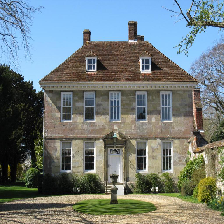

In [18]:
# 변환전 이미지 표시
img_test

**예제 코드11.17:이미지 변환**

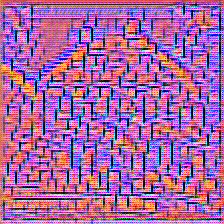

In [19]:
# 모델 적용
pred = model_gen.predict(img_arr_test)

# 변환 후 이미지 표시
img_pred = array_to_img(pred.squeeze())
img_pred